In [13]:
import numpy as np
from numpy.linalg import qr, svd, eig
from scipy.linalg import hadamard, subspace_angles
from sklearn.utils.extmath import randomized_svd

import jax
from jax import jit

import jax.numpy as jnp
from jax import grad, random, vmap
import optax

import math

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.colors as colors

import imageio
import datetime

from utils import *
from kernels import * 

import wandb



In [14]:
from kernel_sca import *
#X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy')
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/MC_Maze/psth.npy').swapaxes(1,2)
d = 3
#epsilon = 1e-3

X, _ = pre_processing(X_init, center=False, soft_normalize='max')
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)
K_A_A = K_X_Y_identity(A, A)

# l = 1
# K_A_X = np.zeros((K*T, K, T))
# for k in range(K):
#     K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X[k], l = l)
# K_A_X = jnp.array(K_A_X)
# K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

#K_A_A = K_A_A + (jnp.eye((K_A_A.shape[0])) * epsilon)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

#np.save('X_centerFalse_softNormMax', X)
#np.save('A_centerFalse_softNormMax', A)
#np.save('P_centerFalse_softNormMax', P)
#np.save('S_centerFalse_softNormMax', S)

In [15]:

wandb.init(project="SCA-project-kernel", name="cpu_local", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X, iterations= 1000, learning_rate= 0.01 )
wandb.finish()

Iteration 0, S: 6.127940650912933e-06, S_ratio: 0.09168097376823425
Iteration 10, S: 1.6202766346395947e-05, S_ratio: 0.15995009243488312
Iteration 20, S: 2.5211104002664797e-05, S_ratio: 0.19349895417690277
Iteration 30, S: 0.00015540167805738747, S_ratio: 0.2575888931751251
Iteration 40, S: 0.00031661370303481817, S_ratio: 0.31061723828315735
Iteration 50, S: 0.0008349874406121671, S_ratio: 0.27800777554512024
Iteration 60, S: 0.004152701236307621, S_ratio: 0.38894981145858765
Iteration 70, S: 0.01249635312706232, S_ratio: 0.30942079424858093
Iteration 80, S: 0.035212550312280655, S_ratio: 0.41520270705223083
Iteration 90, S: 0.14397701621055603, S_ratio: 0.4167494475841522
Iteration 100, S: 0.3180750906467438, S_ratio: 0.5000301003456116
Iteration 110, S: 0.6139287948608398, S_ratio: 0.5117133259773254
Iteration 120, S: 0.9032750725746155, S_ratio: 1.0318422317504883
Iteration 130, S: 1.4836432933807373, S_ratio: 0.5595166087150574
Iteration 140, S: 2.3948943614959717, S_ratio: 0.59

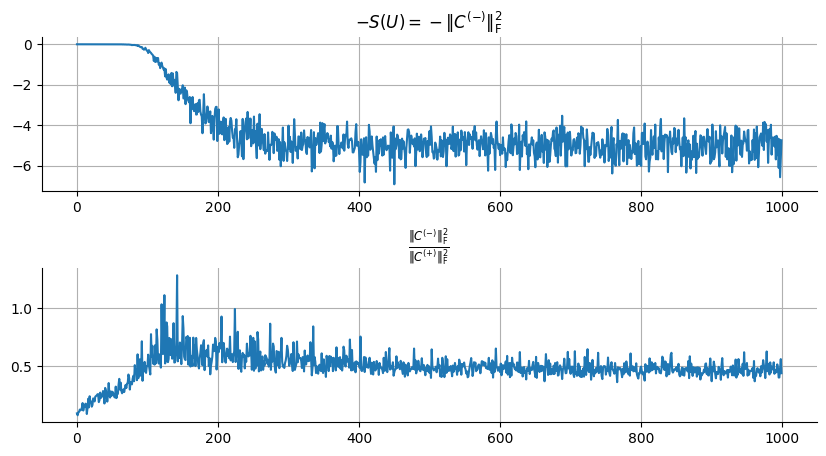

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 0.92, '0.46972921')

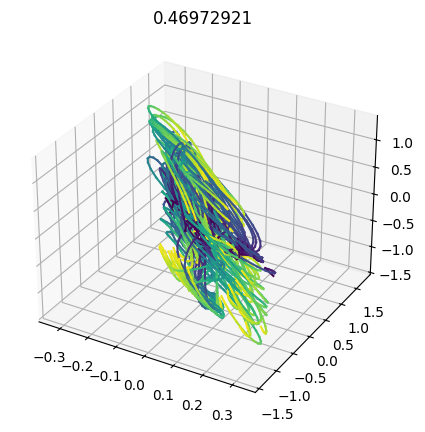

In [17]:
#alpha_tilde = np.load("/Users/ariellerosinski/Desktop/a_500_clust_reorganised_loadX_2.npy")
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde)
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_3D(projection)
plt.title(compute_S_all_pairs(projection))

# np.save('alpha_tilde', alpha_tilde)
# np.save('projection', projection)

Inducing points

In [3]:
from kernel_sca_inducing_points import * 

X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/Churchland/churchland.npy')
d = 3

X, _ = pre_processing(X_init, center=False, soft_normalize='max')
K, N, T = X.shape
A = jnp.swapaxes(X, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

params, ls_loss, ls_S_ratio = optimize(X, A, iterations=100, learning_rate=0.1, d=3, c=20, kernel_function='gaussian')

Iteration 0, S: 3.822499548792067e-16, S_ratio: 3.014713172433403e-07
Iteration 10, S: 1.1439398690457625e-12, S_ratio: 1.0753086826298386e-05
Iteration 20, S: -1.2321755816869264e-18, S_ratio: -1.709821954160029e-12


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

Text(0.5, 0.92, 's = 0.2477823793888092')

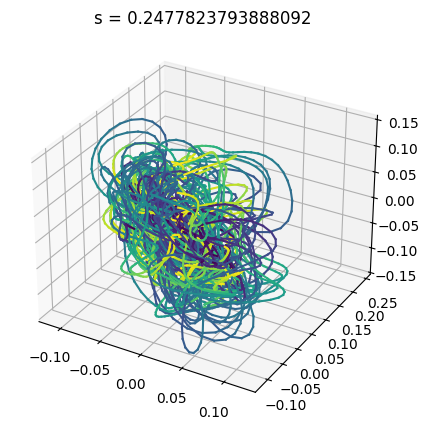

In [13]:
kernel_function='gaussian'
alpha_tilde, u, l, sigma_f = get_params(params, kernel_function=kernel_function)

d = 3
alpha, K_A_u, K_u_u, H_K_A_u, K_u_u_inv = get_alpha(params, A, X, kernel_function=kernel_function)

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

K_A_X = jnp.zeros((K*T, K, T))
for k in range(K):
    K_u_X = K_X_Y_squared_exponential(u, X[k], l=l, sigma_f=sigma_f)
    K_A_X = K_A_X.at[:, k, :].set( jnp.einsum('kc,cj,jm ->km',  K_A_u, K_u_u_inv, K_u_X) )

projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


projection, _ = pre_processing(projection, pca=False, soft_normalize=None)
plot_3D(projection[:,:,:])
plt.title(f's = {compute_S_all_pairs(projection)}')

Other

In [ ]:
U = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/linear_sca/optimized_U_linear_SCA/U_churchland_0.001_10000_3d.npy')
U_qr, _ = jnp.linalg.qr(U)
Y = jnp.einsum('ji,kjl->kil', U_qr, pre_processing(X_init, soft_normalize='max')[0])

Q_Y, _ = qr(Y.swapaxes(1,2).reshape(-1,d))
Q_projection, _ = qr(projection.swapaxes(1,2).reshape(-1,d))
np.rad2deg(subspace_angles(Q_Y, Q_projection))[-1]


80.07225

In [9]:
fig = go.Figure()
num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]
    y = projection[i, 1, :]
    z = projection[i, 2, :]

    for t in range(num_time_points - 1):
        color_scale = colors.sequential.Viridis
        color_index = int(t / (num_time_points - 1) * (len(color_scale) - 1))
        fig.add_trace(go.Scatter3d(
            x=x[t:t+2],
            y=y[t:t+2],
            z=z[t:t+2],
            mode='lines',
            line=dict(color=color_scale[color_index]),
            showlegend=False
        ))
fig.show()
